# Set Up

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [14]:
import zipfile

# Define the zip file and destination folder
zip_path = r'../data/interim/df_mouse_p1p2.zip'  
extract_folder = "../data/interim/unzipped/"  

# Unzip the folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Extracted to {extract_folder}")

# Unzipped data will be gitignored

Extracted to ../data/interim/unzipped/


In [15]:
# Load the data
file_path = "../data/interim/unzipped/df_mouse_p1p2.csv"
df = pd.read_csv(file_path)

# Drop duplicates, drop NAs, and sort values
df = df.drop_duplicates(subset=['session_id', 'mousemove_times'], keep='first')
df = df.sort_values(by=['session_id', 'mousemove_times']).reset_index(drop=True)
df = df.dropna(subset=['session_id', 'mousemove_times', 'mousemove_type', 'mousemove_behaviour', 'label'])

# Extract the mousemove_x and mousemove_y coordinates from the 'mousemove_behaviour' string column
df[['mousemove_x', 'mousemove_y']] = df['mousemove_behaviour'].str.replace(r'[()]', '', regex=True).str.split(',', expand=True)

# Convert mousemove_x and mousemove_y to integer type
df['mousemove_x'] = df['mousemove_x'].astype(int)
df['mousemove_y'] = df['mousemove_y'].astype(int)

/var/folders/y4/lw6k9pr97v32ftq68tmqp5w00000gn/T/ipykernel_73355/2060795491.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [16]:
# See movement types
df['mousemove_type'].value_counts()

mousemove_type
m     3629497
cl       6710
c        1922
cr        153
cm         64
cu          6
Name: count, dtype: int64

In [17]:
df

,session_id,mousemove_times,mousemove_type,mousemove_behaviour,label,mousemove_client_height_width,mousemove_x,mousemove_y
0,03jt2p4bdru20sjb9me2gco6j4,212340127,cl,"(115,497)",human,"(975, 1920)",115,497
1,03jt2p4bdru20sjb9me2gco6j4,212650194,cl,"(121,314)",human,"(975, 1903)",121,314
2,03jt2p4bdru20sjb9me2gco6j4,212756263,cl,"(77,219)",human,"(975, 1920)",77,219
3,03jt2p4bdru20sjb9me2gco6j4,212822729,cl,"(276,744)",human,"(975, 1903)",276,744
4,03jt2p4bdru20sjb9me2gco6j4,212848259,cl,"(118,196)",human,"(975, 1920)",118,196
...,...,...,...,...,...,...,...,...
3639211,vu3fio88psda005g91fbjona0v,1606295812254,m,"(81,573)",moderate_bot,"(847, 1813)",81,573
3639212,vu3fio88psda005g91fbjona0v,1606295812272,m,"(80,573)",moderate_bot,"(847, 1813)",80,573
3639213,vu3fio88psda005g91fbjona0v,1606295812288,m,"(79,573)",moderate_bot,"(847, 1813)",79,573
3639214,vu3fio88psda005g91fbjona0v,1606295812305,m,"(78,574)",moderate_bot,"(847, 1813)",78,574


In [18]:
# Define custom order for results display
custom_order = ['moderate_bot', 'advanced_bot', 'human']

# Analysis 

### Sessions and click frequency

In [19]:
summary_data = []

df_sessions = df.copy()
df_sessions['session_max_time'] = df_sessions.groupby('session_id')['mousemove_times'].transform('max')
df_sessions['session_min_time'] = df_sessions.groupby('session_id')['mousemove_times'].transform('min')
df_sessions['durations'] = df_sessions['session_max_time'] - df_sessions['session_min_time']

for label, group in df_sessions.groupby('label'):
    
    # Count the number of sessions
    unique_sessions = group['session_id'].nunique()

    # Count the total duration of all sessions
    total_duration = group['durations'].sum()

    # Filter for clicks and count the number of clicks
    filtered_group = group[group['mousemove_type'] != 'm']
    total_clicks = len(filtered_group)

    # Add to summary 
    summary_data.append({
        'Label': label,
        'Sessions Count': unique_sessions,
        'Total Duration': total_duration,
        'Total Clicks': total_clicks,
        'Avg Clicks/Session': round(total_clicks / unique_sessions) if unique_sessions > 0 else 0,
        'Click Frequency': total_clicks / total_duration if total_duration > 0 else 0
    })

# Show summary
df_summary = pd.DataFrame(summary_data)
df_summary['Label'] = pd.Categorical(df_summary['Label'], categories=custom_order, ordered=True)
df_summary = df_summary.sort_values('Label')
df_summary

# Humans have higher click frequency than bots 
# Humans have higher average clicks per session than bots

# Features that can be added: duration of session, total number of clicks per session, and click frequency

,Label,Sessions Count,Total Duration,Total Clicks,Avg Clicks/Session,Click Frequency
2,moderate_bot,170,1180641390324537697,2357,14,1.996372e-15
0,advanced_bot,170,1889324586318229571,2433,14,1.287762e-15
1,human,109,998429486436134938,4065,37,4.071394e-15


### Click coordinates

In [20]:
df['mousemove_x'].describe().astype(int)
# (0, 2600)

count    3638352
mean         636
std          397
min            0
25%          311
50%          584
75%          940
max         2519
Name: mousemove_x, dtype: int64

In [21]:
df['mousemove_y'].describe().astype(int)
# (0, 1800)

count    3638352
mean         387
std          162
min            0
25%          267
50%          349
75%          481
max         1775
Name: mousemove_y, dtype: int64

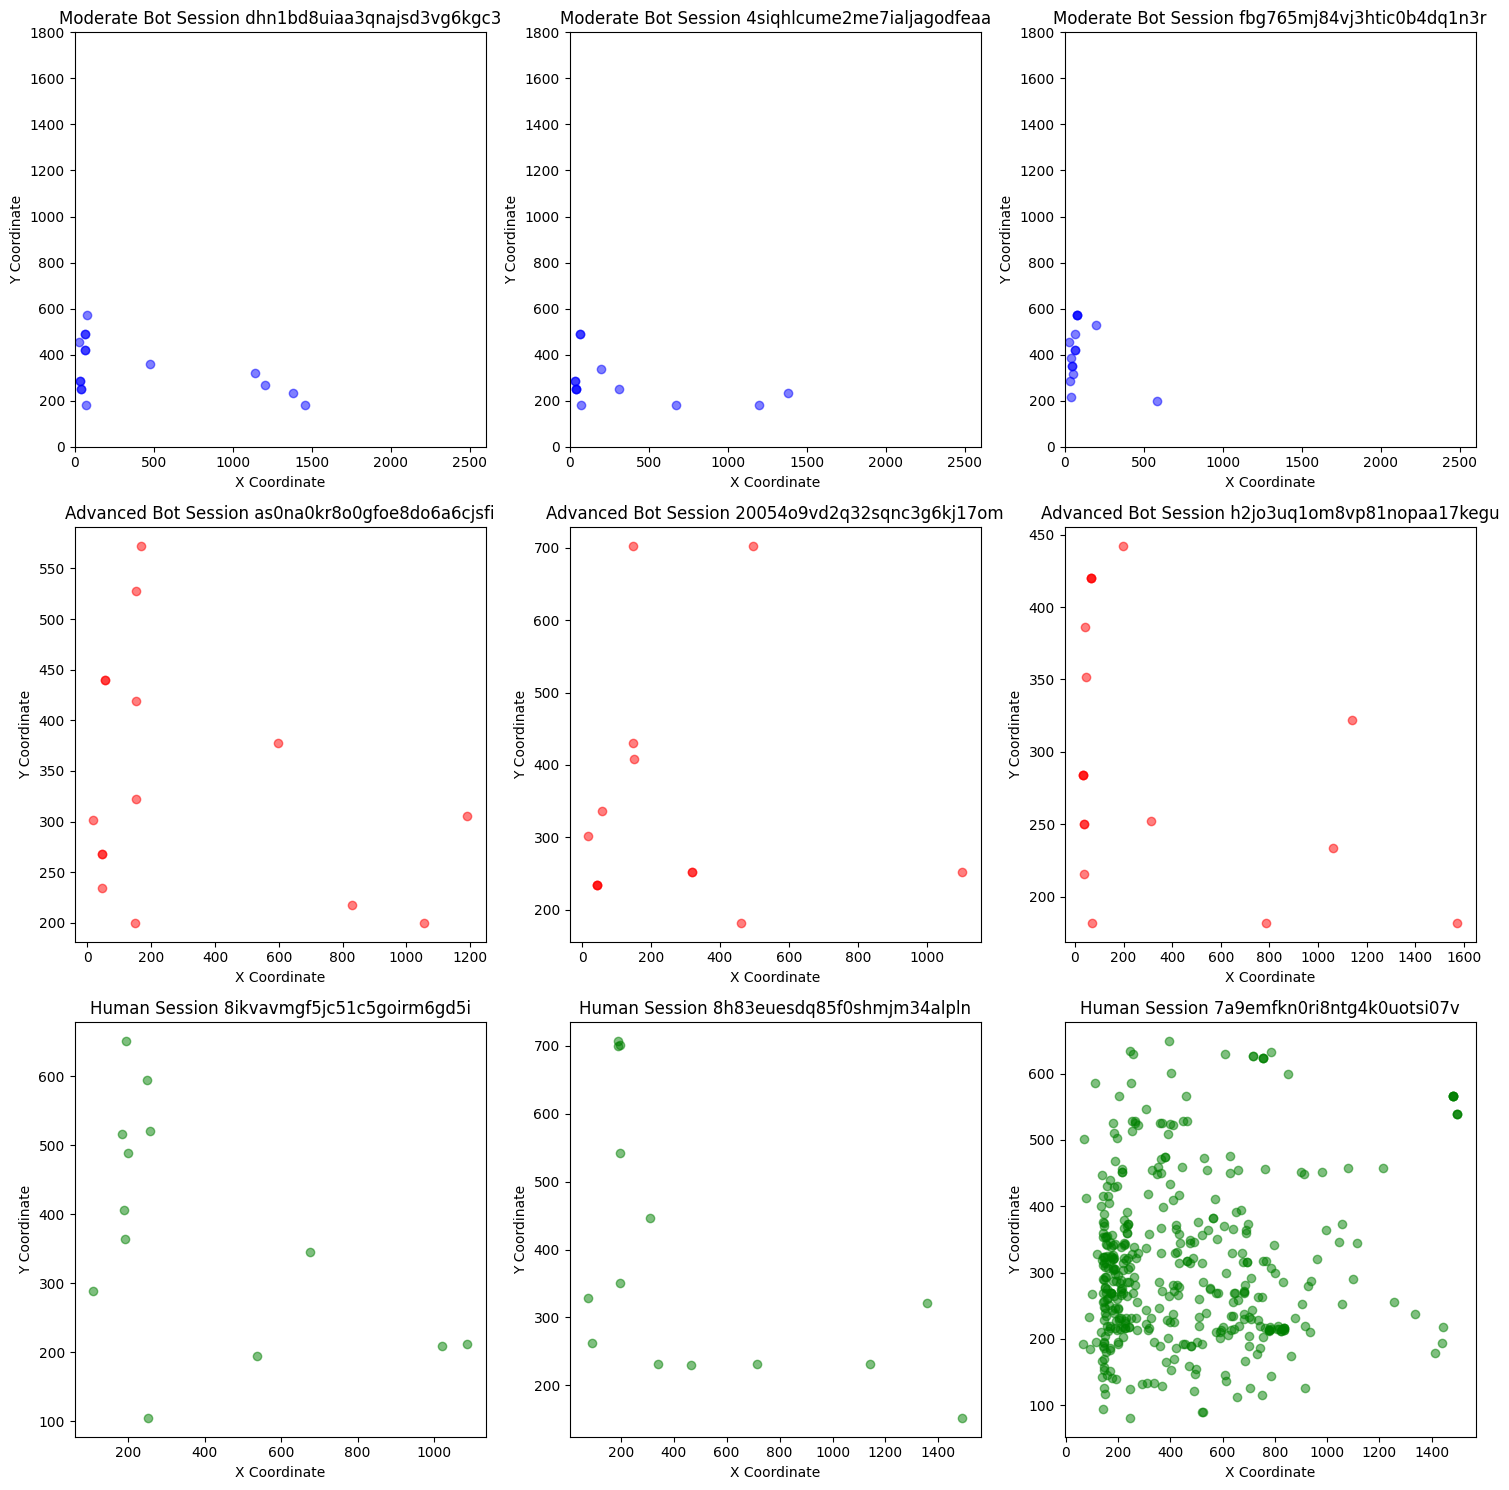

In [22]:
df_clicks = df[df['mousemove_type']!='m']

# Separate moderate_bot, advanced_bot, and human data
moderate_bot_data = df_clicks[df_clicks['label'] == 'moderate_bot']
advanced_bot_data = df_clicks[df_clicks['label'] == 'advanced_bot']
human_data = df_clicks[df_clicks['label'] == 'human']

# Randomly select 3 sessions from each group
selected_moderate_bot_sessions = random.sample(list(moderate_bot_data['session_id']), 3)
selected_advanced_bot_sessions = random.sample(list(advanced_bot_data['session_id']), 3)
selected_human_sessions = random.sample(list(human_data['session_id']), 3)

# Set up the plotting area: 3 rows (one for each category) and 3 columns
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Plot for moderate_bot sessions
for i, session in enumerate(selected_moderate_bot_sessions):
    session_data = moderate_bot_data[moderate_bot_data['session_id'] == session]
    axs[0, i].scatter(session_data['mousemove_x'], session_data['mousemove_y'], alpha=0.5, c='blue')
    axs[0, i].set_title(f'Moderate Bot Session {session}')
    axs[0, i].set_xlabel('X Coordinate')
    axs[0, i].set_ylabel('Y Coordinate')
    axs[0, i].set_xlim(0, 2600) 
    axs[0, i].set_ylim(0, 1800) 

# Plot for advanced_bot sessions
for i, session in enumerate(selected_advanced_bot_sessions):
    session_data = advanced_bot_data[advanced_bot_data['session_id'] == session]
    axs[1, i].scatter(session_data['mousemove_x'], session_data['mousemove_y'], alpha=0.5, c='red')
    axs[1, i].set_title(f'Advanced Bot Session {session}')
    axs[1, i].set_xlabel('X Coordinate')
    axs[1, i].set_ylabel('Y Coordinate')
    axs[0, i].set_xlim(0, 2600) 
    axs[0, i].set_ylim(0, 1800) 

# Plot for human sessions
for i, session in enumerate(selected_human_sessions):
    session_data = human_data[human_data['session_id'] == session]
    axs[2, i].scatter(session_data['mousemove_x'], session_data['mousemove_y'], alpha=0.5, c='green')
    axs[2, i].set_title(f'Human Session {session}')
    axs[2, i].set_xlabel('X Coordinate')
    axs[2, i].set_ylabel('Y Coordinate')
    axs[0, i].set_xlim(0, 2600) 
    axs[0, i].set_ylim(0, 1800) 

# Adjust layout
plt.tight_layout()
plt.show()


In [23]:
# Entropy of click coordinates 
df_entropy = df_clicks.copy()

# Define grid size (e.g., 100x100 pixels per grid cell)
grid_size = 100

def calculate_session_entropy(df_entropy, grid_size):
    # Discretize the coordinates into grid cells (vectorized operation)
    df_entropy['mousemove_x'] = df_entropy['mousemove_x'] // grid_size
    df_entropy['mousemove_y'] = df_entropy['mousemove_y'] // grid_size
    
    # Group by session_id and label, calculate frequencies for each session
    grouped = df_entropy.groupby(['session_id', 'label', 'mousemove_x', 'mousemove_y']).size().reset_index(name='count')

    # Calculate total visits per session (needed for probability calculation)
    session_totals = grouped.groupby(['session_id', 'label'])['count'].transform('sum')
    
    # Calculate probabilities
    grouped['probability'] = grouped['count'] / session_totals
    
    # Calculate entropy using Shannon's formula
    grouped['entropy_part'] = -grouped['probability'] * np.log2(grouped['probability'] + np.finfo(float).eps)
    
    # Aggregate entropy for each session_id and label
    entropy_data = grouped.groupby(['session_id', 'label'])['entropy_part'].sum().reset_index(name='entropy')
    
    return entropy_data

# Example usage
session_entropy_df = calculate_session_entropy(df_entropy, grid_size)
session_entropy_df['label'] = pd.Categorical(session_entropy_df['label'], categories=custom_order, ordered=True)
session_entropy_df

,session_id,label,entropy
0,03jt2p4bdru20sjb9me2gco6j4,human,3.121928
1,071tbv7fsev5d64kb0f9jieor6,advanced_bot,3.221097
2,094i85crhkpkhqpi3rl4athrn4,advanced_bot,2.895424
3,0ht0u328t4mkgi01sp7mm07e01,moderate_bot,2.446439
4,0i5kvpslrq3vb6u8ff2kuejv0v,advanced_bot,3.452820
...,...,...,...
444,vmgkfqtair7fq7kqqr6kpqm9st,moderate_bot,2.694781
445,vofhhjsbkpj6kc9it95e76nu1a,human,4.626272
446,vopb1c4o3o2dpsov8jinbbou5h,human,3.521641
447,vtcjrbtjq57mnai4banl61pd25,advanced_bot,3.110578


In [24]:
session_entropy_df.groupby('label', observed=True)['entropy'].describe()

# Features that can be added: entropy of click coordinates

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
moderate_bot,170.0,2.600071,0.345173,1.500000,2.393426,2.625815,2.859770,3.327820
advanced_bot,170.0,2.853531,0.397364,1.488525,2.648216,2.852217,3.106882,3.721612
human,109.0,3.677618,0.787472,2.000000,3.121928,3.546439,4.271371,5.695357


# Output

In [31]:
session_entropy_df = session_entropy_df[['session_id', 'entropy']]
session_entropy_df.to_csv("../data/interim/mouseclick_entropy.csv", index=False)

In [32]:
df_sessions = df.copy()

# Aggregate session-level metrics
df_sessions = df_sessions.groupby('session_id').agg(
    session_max_time=('mousemove_times', 'max'),
    session_min_time=('mousemove_times', 'min'),
    clicks_count=('mousemove_type', lambda x: (x != 'm').sum())
).reset_index()

# Calculate session duration
df_sessions['durations'] = df_sessions['session_max_time'] - df_sessions['session_min_time']

# Avoid division by zero and compute click frequency
df_sessions['click_frequency'] = df_sessions['clicks_count'] / df_sessions['durations'].replace(0, np.nan)

df_sessions = df_sessions[['session_id', 'clicks_count', 'durations', 'click_frequency']]
df_sessions.to_csv("../data/interim/mouseclick_frequency.csv", index=False)
